# Classifying Images with a NN and DNN Model

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using a Deep Neural Network Model.

## Learning Objectives

* Define Helper Functions.
* Train and evaluate a Neural Network (NN) model.
* Train and evaluate a Deep Neural Network model.


Each learning objective will correspond to a __#TODO__ in the student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/classifying_images_with_a_nn_and_dnn_model.ipynb).


In [1]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2.6.5


In [2]:
conda install graphviz

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       h04ea711_2         348 KB  conda-forge
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    cairo-1.18.0               |       h3faef2a_0         959 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.5.0               |   py39hf3d152e_0         927 KB  conda-forge
    expat-2.6.2                |       h59595ed_0         134 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed

## Defining Helper Functions
#### Reading and Preprocessing image data

In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [4]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-07-18 19:29:34.284818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-18 19:29:34.284864: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-18 19:29:34.284896: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240718-132247): /proc/driver/nvidia/version does not exist
2024-07-18 19:29:34.288565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train and evaluate a Neural Network (NN) model

One way to get a more complex method is to interpose one or more Dense layers in between the input and output. The model now has three layers. A layer with trainable weights such as the one recently added, that is neither the input nor the output, is called a hidden layer.

In Keras, you introduce the activation function with tf.keras.activations.

The Rectified Linear Unit (ReLU) is the most commonly used activation function for hidden layers – other commonly used activation functions include sigmoid, tanh, and elu.

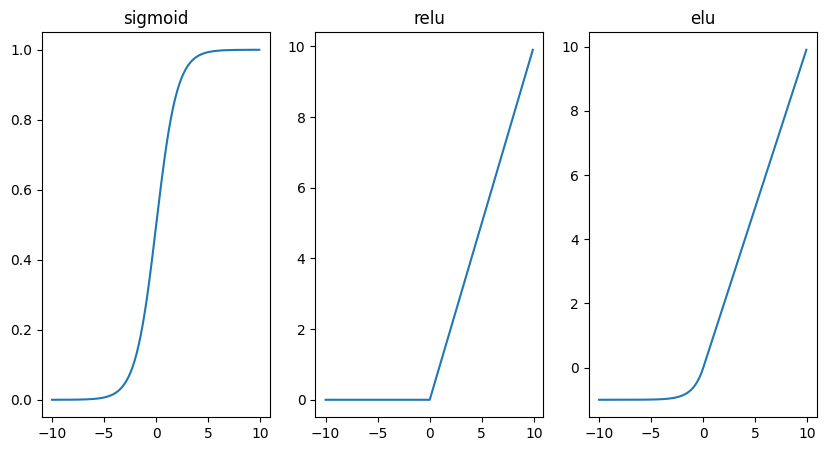

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


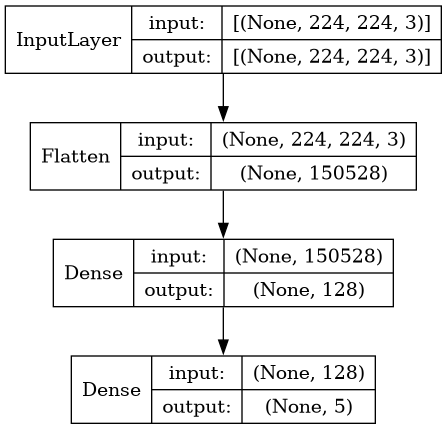

In [6]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [7]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [8]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# TODO 2: Train a Neural Network model
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)


2024-07-18 19:30:52.458541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
104/104 [==============================] - 75s 712ms/step - loss: 11.7092 - accuracy: 0.2988 - val_loss: 2.1385 - val_accuracy: 0.3514
Epoch 2/10
104/104 [==============================] - 71s 680ms/step - loss: 2.1507 - accuracy: 0.3745 - val_loss: 2.0197 - val_accuracy: 0.3054
Epoch 3/10
104/104 [==============================] - 70s 671ms/step - loss: 1.6233 - accuracy: 0.2445 - val_loss: 1.6042 - val_accuracy: 0.2270
Epoch 4/10
104/104 [==============================] - 71s 683ms/step - loss: 1.5957 - accuracy: 0.2252 - val_loss: 1.5976 - val_accuracy: 0.2216
Epoch 5/10
104/104 [==============================] - 70s 676ms/step - loss: 1.5775 - accuracy: 0.2239 - val_loss: 1.5994 - val_accuracy: 0.2351
Epoch 6/10
104/104 [==============================] - 72s 692ms/step - loss: 1.5897 - accuracy: 0.2458 - val_loss: 1.5969 - val_accuracy: 0.2351
Epoch 7/10
104/104 [==============================] - 71s 687ms/step - loss: 1.5873 - accuracy: 0.2458 - val_loss: 1.7272 - val_a

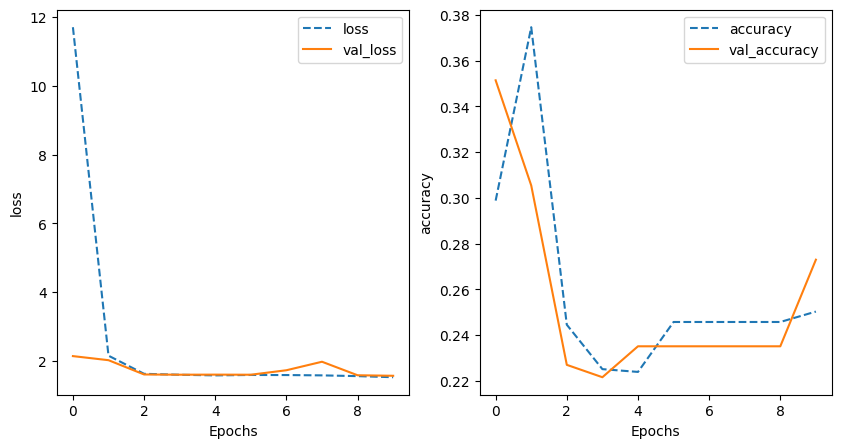

In [9]:
training_plot(['loss', 'accuracy'], history)

## Training the neural network

Training the neural network is similar to training the linear model. Compile the model passing in the optimizer, the loss, and the metrics. Then, call model.fit() passing in the datasets.

In [10]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

First, train your model by using 128 hidden layers.

Epoch 1/10
104/104 [==============================] - 71s 680ms/step - loss: 2.0192 - accuracy: 0.3588 - val_loss: 1.5149 - val_accuracy: 0.4000
Epoch 2/10
104/104 [==============================] - 71s 685ms/step - loss: 1.3739 - accuracy: 0.4258 - val_loss: 1.2337 - val_accuracy: 0.4595
Epoch 3/10
104/104 [==============================] - 71s 677ms/step - loss: 1.2962 - accuracy: 0.4703 - val_loss: 1.2093 - val_accuracy: 0.4946
Epoch 4/10
104/104 [==============================] - 71s 681ms/step - loss: 1.2414 - accuracy: 0.4912 - val_loss: 1.1993 - val_accuracy: 0.4946
Epoch 5/10
104/104 [==============================] - 71s 683ms/step - loss: 1.1961 - accuracy: 0.5148 - val_loss: 1.2080 - val_accuracy: 0.4919
Epoch 6/10
104/104 [==============================] - 73s 700ms/step - loss: 1.1453 - accuracy: 0.5303 - val_loss: 1.2876 - val_accuracy: 0.4703
Epoch 7/10
104/104 [==============================] - 71s 686ms/step - loss: 1.1145 - accuracy: 0.5527 - val_loss: 1.3464 - val_ac

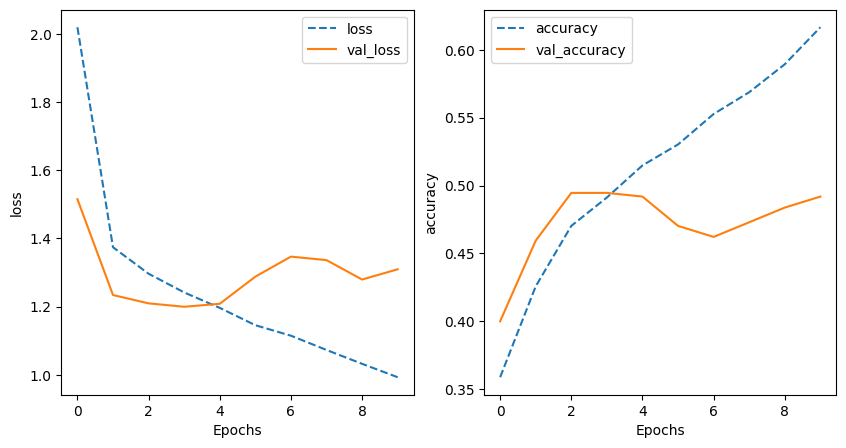

In [11]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

You would normally expect that adding layers to a model will improve the ability of the model to fit the training data, and thus lower the loss. Notice that it is not always the case though.

Epoch 1/10
104/104 [==============================] - 75s 720ms/step - loss: 2.6014 - accuracy: 0.3476 - val_loss: 1.7357 - val_accuracy: 0.3676
Epoch 2/10
104/104 [==============================] - 75s 723ms/step - loss: 1.7946 - accuracy: 0.4152 - val_loss: 2.4561 - val_accuracy: 0.3541
Epoch 3/10
104/104 [==============================] - 75s 716ms/step - loss: 1.6117 - accuracy: 0.4445 - val_loss: 1.6993 - val_accuracy: 0.4297
Epoch 4/10
104/104 [==============================] - 74s 714ms/step - loss: 1.4016 - accuracy: 0.4873 - val_loss: 1.5735 - val_accuracy: 0.4541
Epoch 5/10
104/104 [==============================] - 76s 734ms/step - loss: 1.2967 - accuracy: 0.5303 - val_loss: 1.4125 - val_accuracy: 0.4595
Epoch 6/10
104/104 [==============================] - 77s 735ms/step - loss: 1.2399 - accuracy: 0.5494 - val_loss: 1.5884 - val_accuracy: 0.4459
Epoch 7/10
104/104 [==============================] - 77s 739ms/step - loss: 1.2160 - accuracy: 0.5712 - val_loss: 2.3325 - val_ac

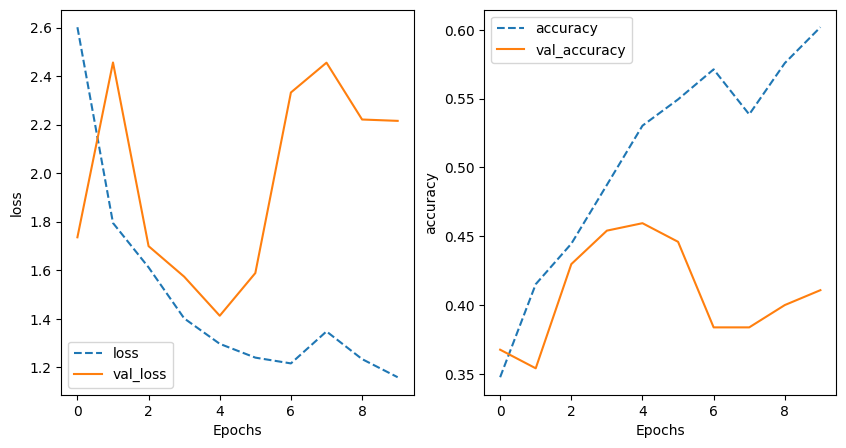

In [12]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

## Train and evaluate a Deep Neural Network model

Now train a DNN. You need to parameterize the number of layers, and the number of nodes in each layer.

In [13]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

In [ ]:
# TODO 3: Train and evaluate a DNN model
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 74s 711ms/step - loss: 1.7796 - accuracy: 0.2906 - val_loss: 1.7123 - val_accuracy: 0.2838
Epoch 2/10
104/104 [==============================] - 72s 689ms/step - loss: 1.7516

Congrats! You've completed the lab!